# Preliminar studies on training samples
It is a good practice to do preliminar studies of the training samples in order to determine the variables to use. Although ML algorithms are powerful, you might experience inefficiencies due to the curse of dimensionality, so using all of them is not a good idea. On the other hand, the set of variables to be chosen is completely problem-dependent. Sometimes we want a ML algorithm focused on kinematic variables only, sometimes focused on particle identification, ... or we can use the output of the classifier in order to directly fit our data. Here you can find some things that are commonly used in many of the previous cases.

A good guide to follow is in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_selection.html).

In [1]:
%matplotlib inline
%run shared.ipynb
import collections
import hep_lessons_ml
import matplotlib.pyplot as plt
import numpy as np
import pandas

from sklearn.tree import DecisionTreeClassifier

## Plotting the distribution of the variables
The simplest thing to do is to plot the distributions of the variables of the different components we want to separate with our ML algorithm and check in which ones the difference is higher. Let's do it with the simulated sample of proton-proton collisions of [this notebook](simulation.ipynb).

In [2]:
sample = sample_to_dataframe('reco_pp_450.0_400000.hdf5', key='root', stop=None)

pid_cond = (sample['p1_pid'] == +211) & (sample['p2_pid'] == -211)  # two pions with opposite sign

head_cond = (sample['p1_head_rid'] == sample['p2_head_rid']) & (sample['p1_head_pid'] == 310)  # common head (a KS0)

sample.loc[:,'signal'] = pid_cond & head_cond

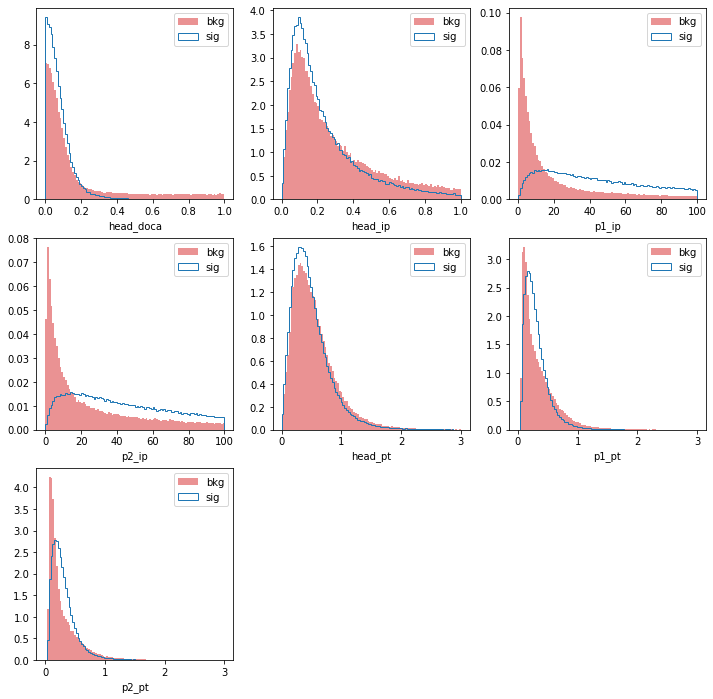

In [3]:
sig, bkg = split_sig_bkg(sample)

variable = collections.namedtuple('variable', ['name', 'bins', 'range'])

variables = [
    variable('head_doca', 100, (0, 1)),
    variable('head_ip', 100, (0, 1)),
    variable('p1_ip', 100, (0, 100)),
    variable('p2_ip', 100, (0, 100)),
    variable('head_pt', 100, (0, 3)),
    variable('p1_pt', 100, (0, 3)),
    variable('p2_pt', 100, (0, 3)),
]

variable_names = [v.name for v in variables]

k = len(variables) // 3 + (len(variables) % 3 != 0)

fig, axs = plt.subplots(k, 3, figsize=(12, k * 4))

axs = axs.flatten()

for v, ax in zip(variables, axs):
    common = dict(bins=v.bins, range=v.range, density=True)
    ax.hist(bkg[v.name], histtype='stepfilled', color='C3', label='bkg', alpha=0.5, **common)
    ax.hist(sig[v.name], histtype='step', color='C0', label='sig', **common)
    ax.set_xlabel(v.name)
    ax.legend()
    
for i in range(axs.size - 1, len(variables) - 1, -1):
    axs[i].set_axis_off()

As you can see, the impact parameter of the decay products, together with the distance of closest approach of the two tracks are the most significative variables at first sight. However, correlation also matters, so including some other variables that do not present big differences might help the classifier.

## Correlation study
The correlation among the variables is also important when training a classifier. This can be easily checked and displayed using an $n \times n$ matrix storing the correlation.

Correlations for signal
           head_doca   head_ip     p1_ip     p2_ip   head_pt     p1_pt  \
head_doca   1.000000  0.016475 -0.023854 -0.025529  0.092581  0.069936   
head_ip     0.016475  1.000000  0.206812  0.199158  0.306226  0.210904   
p1_ip      -0.023854  0.206812  1.000000  0.002877  0.245176  0.363930   
p2_ip      -0.025529  0.199158  0.002877  1.000000  0.242978 -0.020185   
head_pt     0.092581  0.306226  0.245176  0.242978  1.000000  0.666816   
p1_pt       0.069936  0.210904  0.363930 -0.020185  0.666816  1.000000   
p2_pt       0.075862  0.203188 -0.020128  0.359179  0.671580 -0.057470   

              p2_pt  
head_doca  0.075862  
head_ip    0.203188  
p1_ip     -0.020128  
p2_ip      0.359179  
head_pt    0.671580  
p1_pt     -0.057470  
p2_pt      1.000000  
Correlations for background
           head_doca   head_ip     p1_ip     p2_ip   head_pt     p1_pt  \
head_doca   1.000000  0.271096  0.089726  0.022740 -0.011646  0.046379   
head_ip     0.271096  1.000000 

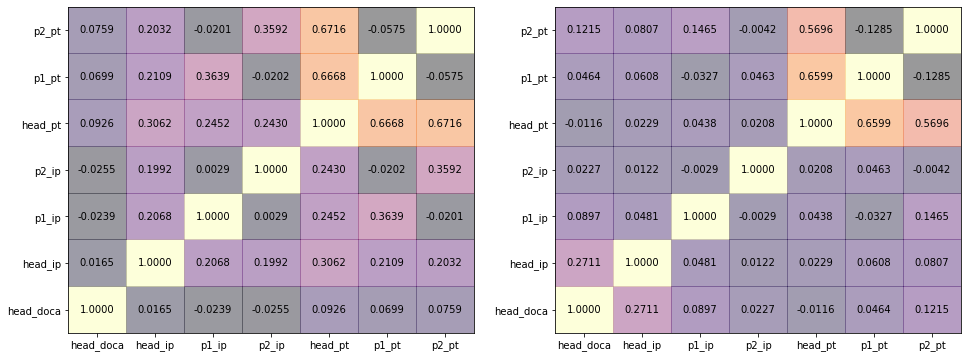

In [4]:
sig_corr = sample[sample['signal']][variable_names].corr()

print(f'Correlations for signal\n{sig_corr}')

bkg_corr = sample[~sample['signal']][variable_names].corr()

print(f'Correlations for background\n{bkg_corr}')

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

for corr, ax in ((sig_corr, ax0), (bkg_corr, ax1)):
    
    edges = np.arange(1, len(corr.columns) + 2)

    centers = 0.5 * (edges[1:] + edges[:-1])

    x, y = tuple(a.flatten() for a in np.meshgrid(centers, centers))

    _, _, _, obj = ax.hist2d(x, y, bins=(edges, edges), weights=corr.values.flatten(), alpha=0.4, cmap='inferno');

    for ci, v1 in zip(centers, variable_names):
        for cj, v2 in zip(centers, variable_names):
            ax.text(ci, cj, f'{corr.loc[v1, v2]:.4f}', ha='center', va='center')

    ax.set_xticks(centers);
    ax.set_xticklabels(variable_names);
    ax.set_yticks(centers);
    ax.set_yticklabels(variable_names);

You can see that the variables that are more correlated with each other are the transverse momenta of the decay products with that of the head particle.

## Ranking the variables
It is possible to rank the variables and determine which ones will become more important for the classifier during the training. There is no deterministic way to stablish if one variable will be more important than another till we  train the final classifier with them. However, we can get a good estimate doing some preliminar calculations with the help of a preliminar classifier.

In [5]:
clf = DecisionTreeClassifier()
clf.fit(sample[variable_names], sample['signal']);

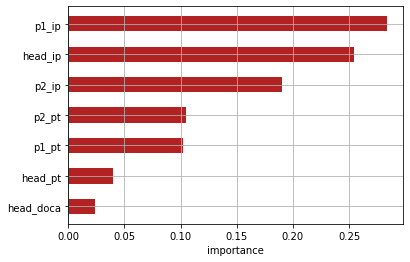

In [6]:
importances, sorted_variables = zip(*sorted(zip(clf.feature_importances_, variables)))

yticks = np.arange(1, len(importances) + 1)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i, im in zip(yticks, importances):
    ax.barh(i, im, height=0.5, color='firebrick')

ax.set_yticks(yticks)
ax.set_yticklabels([v.name for v in sorted_variables]);
ax.set_xlabel('importance')
ax.grid()

## Weighting the samples
When you use simulated candidates, remember the first rule of Monte Carlo (MC) in particle physics: "never trust your MC". In general the simulation will not perfectly reproduce real data. The differences might have an impact on our classifier, making us believe that it's performance is good when it is not. It turns convenient to weight the simulated candidates in such a way that their behaviour becomes closer to that of real data candidates. This can be achieved by doing a *regression* with the help of gradient boosting, for example. A common approach is to find a real data signal candidate that is close to the signal that we want to study, compare its behaviour in data and simulation and train an algorithm to do a regression that later we apply to our simulated signal sample. You can find very simple tools to do this task in the [hep_ml package](https://github.com/arogozhnikov/hep_ml).